# 01 - EDA and Modeling

Notebook skeleton: 
- Chargement des données
- Nettoyage
- EDA
- Construction du pipeline et entraînement
- Évaluation


In [7]:
import os
import sys
import pandas as pd

# Ajouter le dossier parent au PYTHONPATH pour accéder à src/
sys.path.append(os.path.abspath('..'))

from src.telco_churn.data import load_data, basic_cleaning

# Chemin du CSV
path = '../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Charger et nettoyer
try:
    df = load_data(path)
except FileNotFoundError:
    print('Put the dataset CSV at', path)
    df = None

if df is not None:
    df = basic_cleaning(df)
    print("Shape du dataset :", df.shape)
    display(df.head())


Shape du dataset : (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Aperçu général
df.info()

# Statistiques descriptives pour les colonnes numériques
df.describe()

# Afficher les premières lignes
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


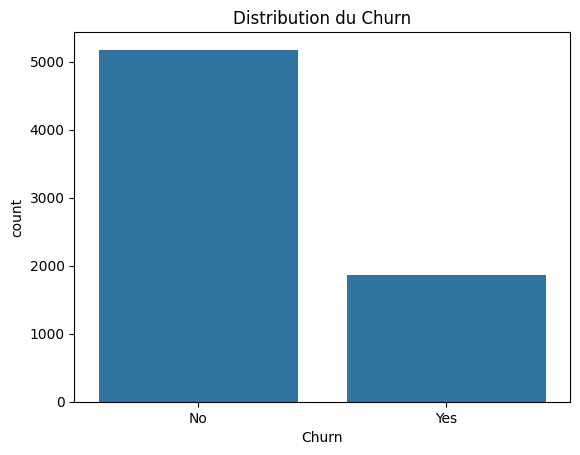

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='Churn')
plt.title("Distribution du Churn")
plt.show()


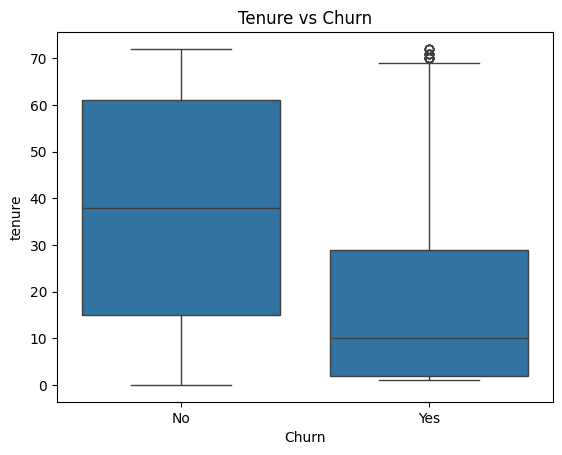

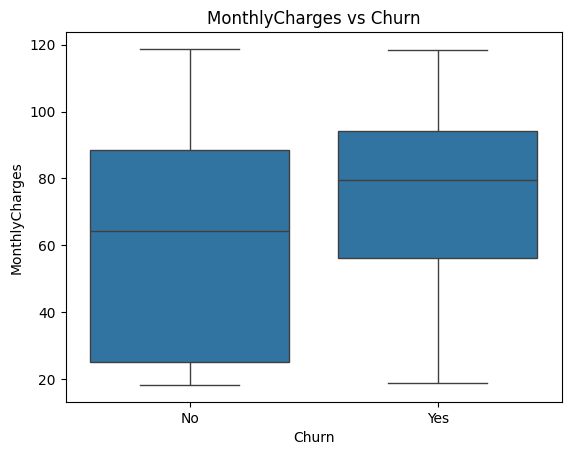

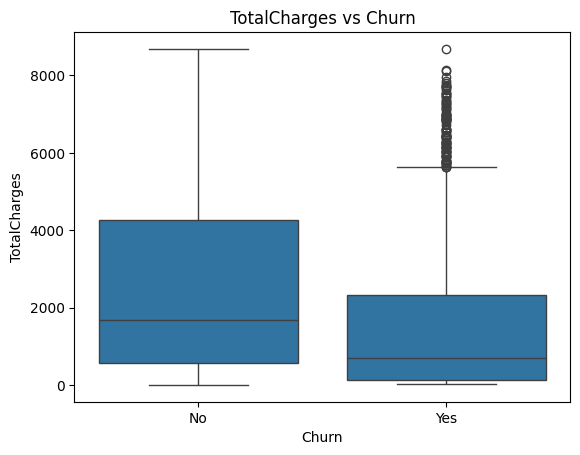

In [10]:
# Tenure vs Churn
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()

# MonthlyCharges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("MonthlyCharges vs Churn")
plt.show()

# TotalCharges vs Churn
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title("TotalCharges vs Churn")
plt.show()



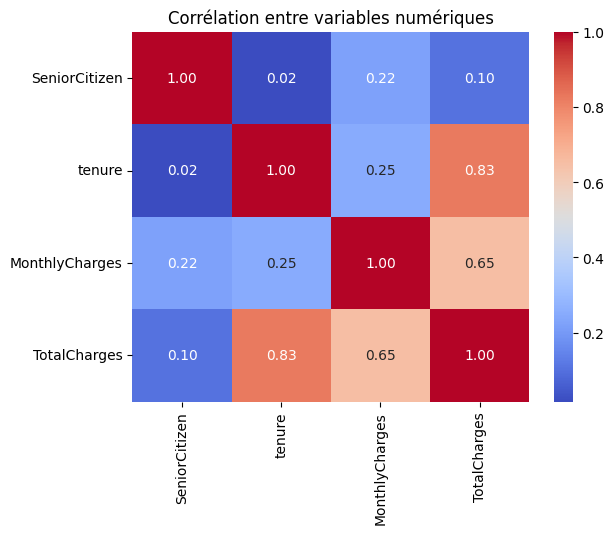

In [12]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Corrélation entre variables numériques")
plt.show()


In [13]:
df['Churn_num'] = df['Churn'].map({'Yes':1, 'No':0})
numeric_df = df[['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','Churn_num']]


In [14]:
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})


In [15]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X.columns if col not in numeric_features]


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0


In [20]:
import os

os.makedirs('models', exist_ok=True)


In [21]:
import joblib

joblib.dump(pipe, 'models/baseline_model.pkl')
print("Modèle sauvegardé dans models/baseline_model.pkl")


Modèle sauvegardé dans models/baseline_model.pkl


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import joblib


os.chdir(r"C:\Users\33695\Desktop\Samir_Fezani_projet3_AIA01")


path = "data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(path)


In [33]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})
df.drop('customerID', axis=1, inplace=True)


C:\Users\33695\AppData\Local\Temp\ipykernel_28852\3428822391.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


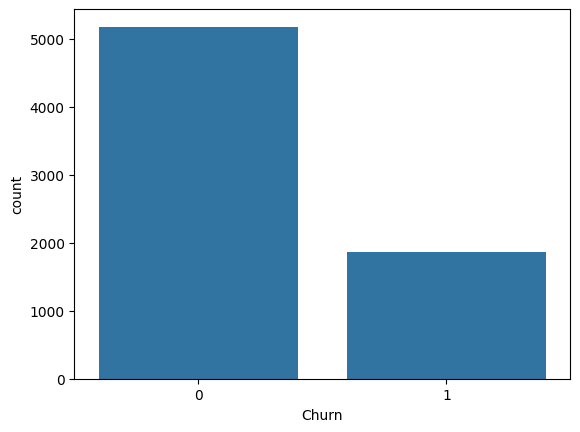

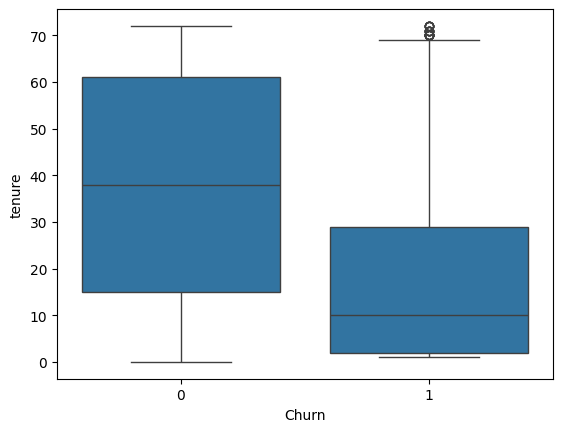

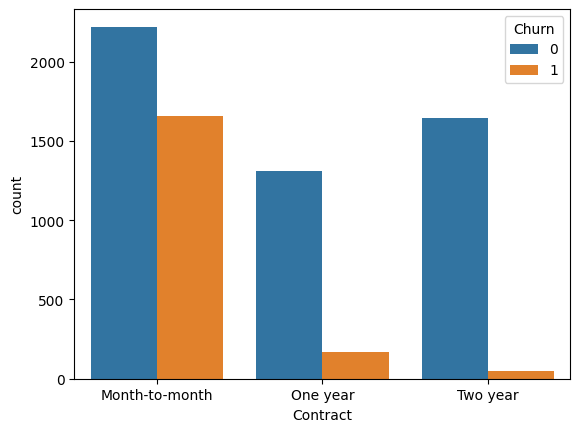

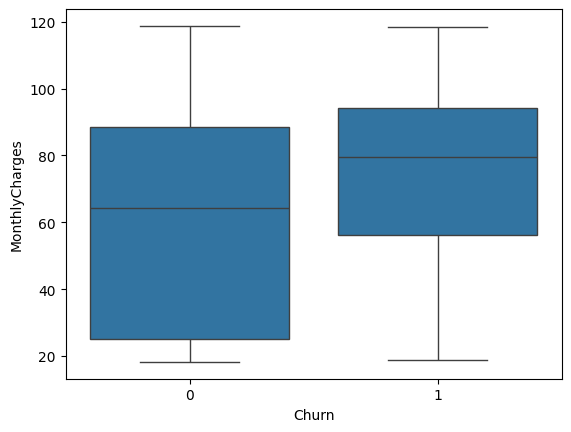

In [34]:
df.info()
df.describe()
sns.countplot(x='Churn', data=df)
plt.show()
sns.boxplot(x='Churn', y='tenure', data=df)
plt.show()
sns.countplot(x='Contract', hue='Churn', data=df)
plt.show()
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.show()


In [35]:
X = df.drop('Churn', axis=1)
y = df['Churn']

numeric_features = ['tenure','MonthlyCharges','TotalCharges','SeniorCitizen']
categorical_features = [col for col in X.columns if col not in numeric_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [38]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [40]:
import os
import joblib


os.makedirs("models", exist_ok=True)


joblib.dump(lr_pipe, "models/baseline_model.pkl")
print("Modèle sauvegardé dans models/baseline_model.pkl")


Modèle sauvegardé dans models/baseline_model.pkl


In [41]:
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr_pipe.predict_proba(X_test)[:,1]))
joblib.dump(lr_pipe, "models/baseline_model.pkl")


Accuracy: 0.8055358410220014
Precision: 0.6572327044025157
Recall: 0.5588235294117647
F1: 0.6040462427745664
ROC AUC: 0.8418739827946988


['models/baseline_model.pkl']

Decision Tree Accuracy: 0.7984386089425124


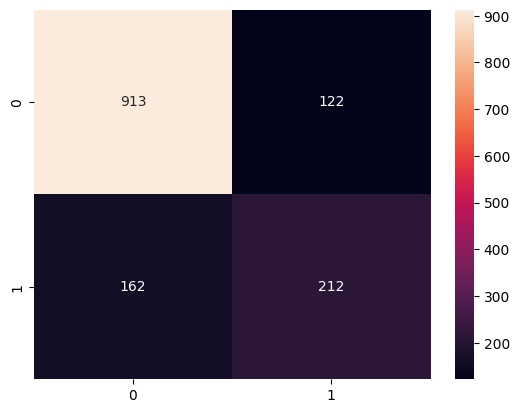

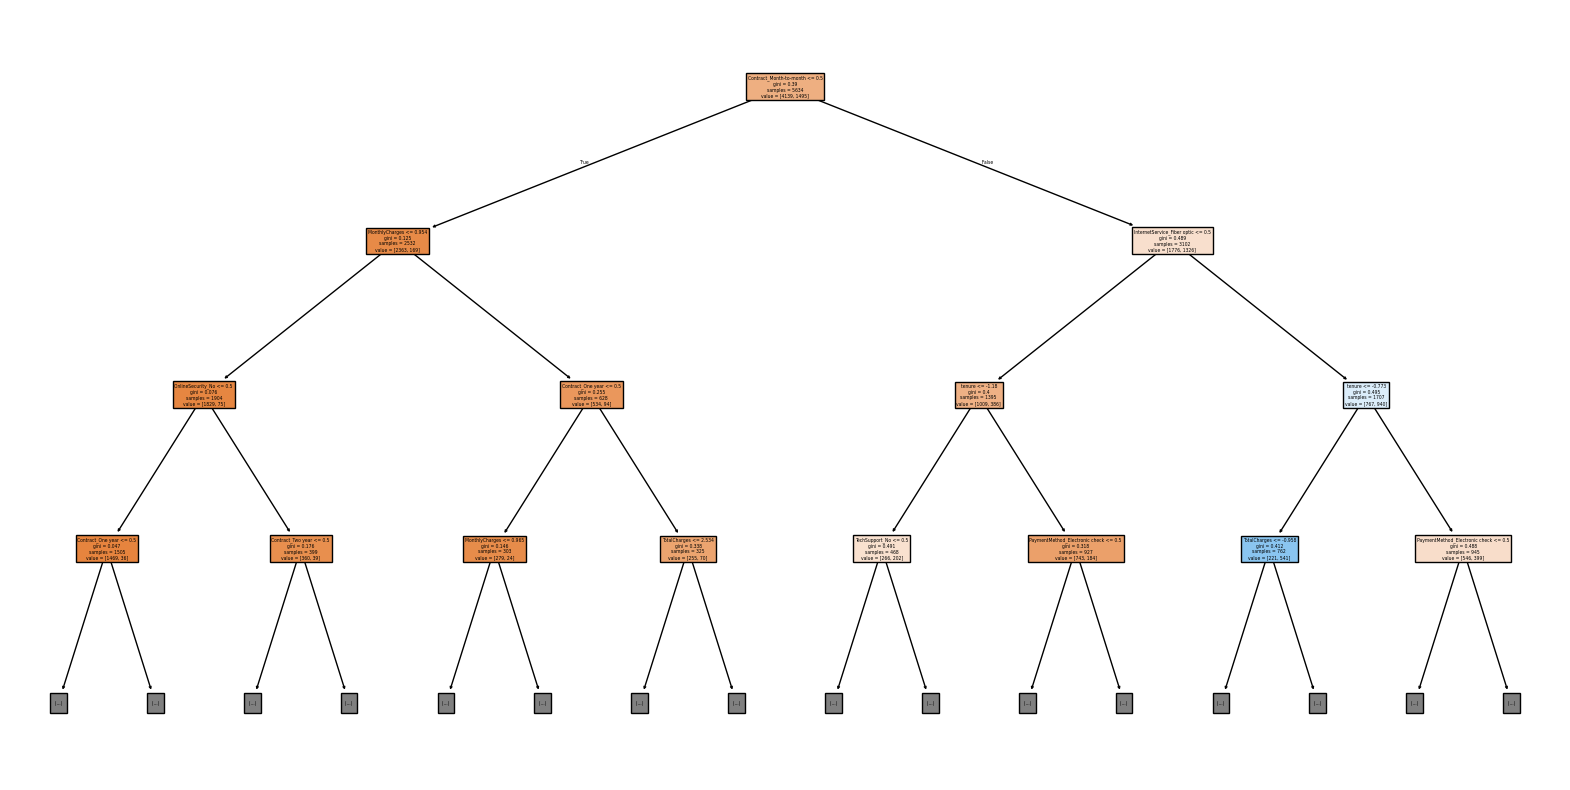

In [42]:
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])

tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
cm = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

plt.figure(figsize=(20,10))
plot_tree(tree_pipe.named_steps['classifier'], 
          feature_names=numeric_features + list(tree_pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)), 
          filled=True, max_depth=3)
plt.show()


Random Forest Accuracy: 0.7849538679914834


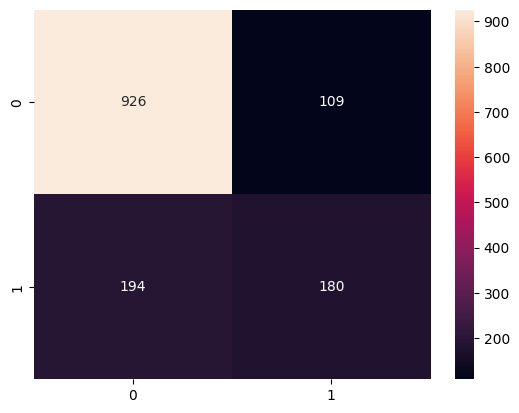

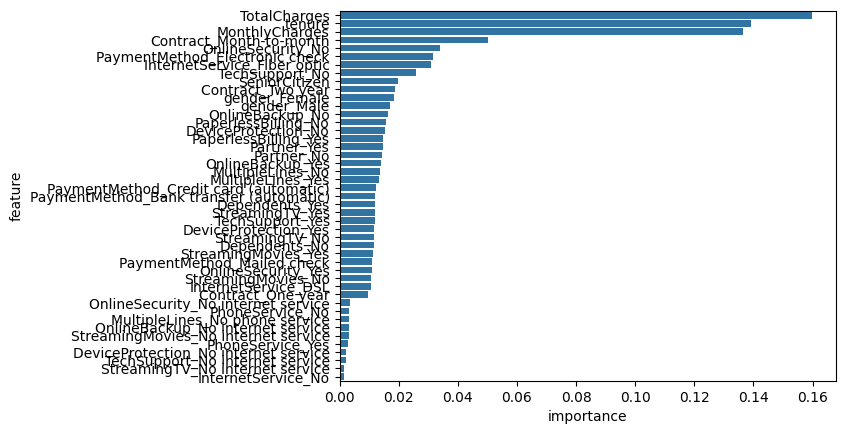

['models/rf_model.pkl']

In [43]:
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

importances = rf_pipe.named_steps['classifier'].feature_importances_
feature_names = numeric_features + list(rf_pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
feat_importance = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.show()

joblib.dump(rf_pipe, "models/rf_model.pkl")


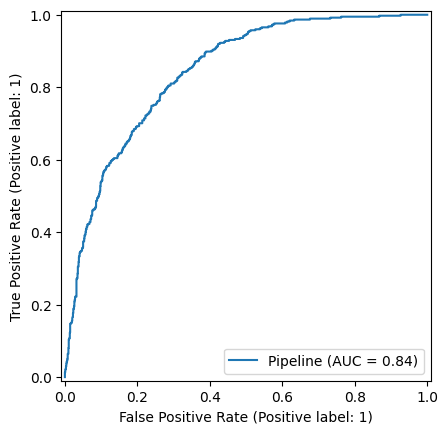

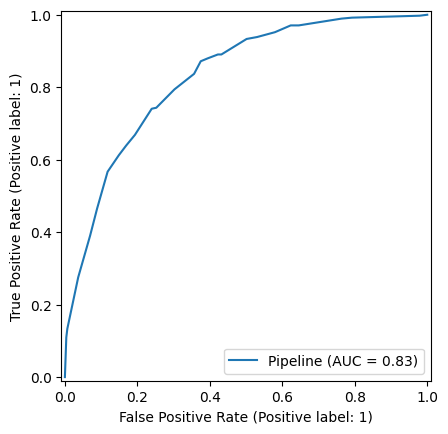

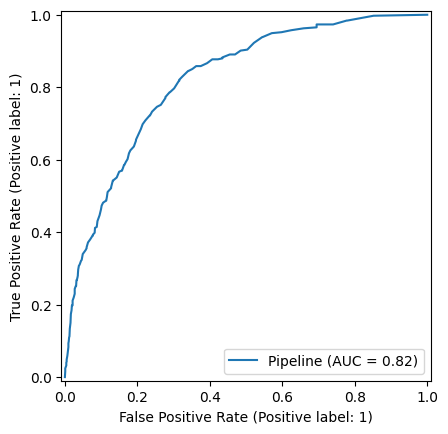

In [44]:
RocCurveDisplay.from_estimator(lr_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(tree_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test)
plt.show()


In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None]
}

grid = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
best_model = grid.best_estimator_


Meilleurs paramètres : {'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [46]:
joblib.dump(best_model, "models/rf_best_model.pkl")


['models/rf_best_model.pkl']

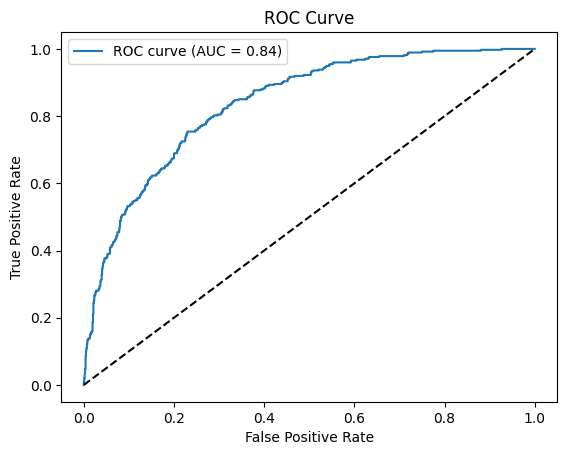

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


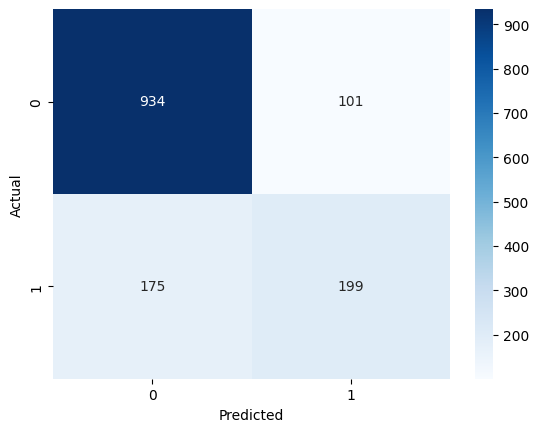

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [50]:
import joblib
joblib.dump(best_model, "models/rf_best_model.pkl")
print("Modèle optimisé sauvegardé dans models/rf_best_model.pkl")


Modèle optimisé sauvegardé dans models/rf_best_model.pkl


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.8041163946061036
Precision: 0.6633333333333333
Recall: 0.5320855614973262
F1: 0.5905044510385756
ROC AUC: 0.8373931127128058


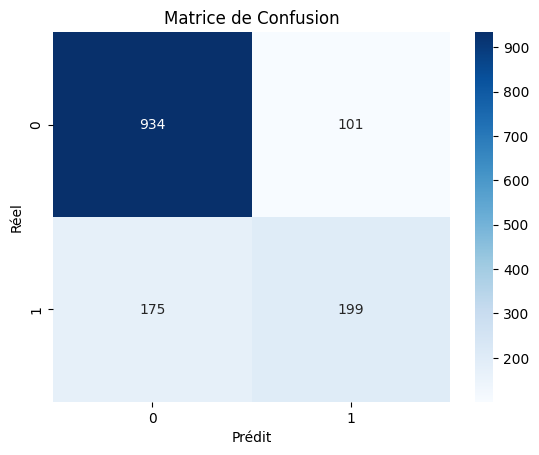

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()


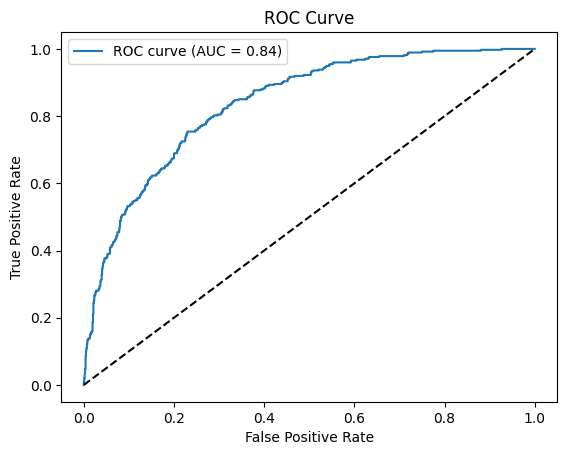

In [53]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [54]:
import joblib
joblib.dump(best_model, "models/rf_best_model.pkl")

['models/rf_best_model.pkl']